In [1]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from scipy import array, linalg, dot
from decimal import Decimal
from scipy.special import expit

In [2]:
# Constants
rho0 = 2
g = 32.2
k = 2e4
R = 10 ** 4
Q = np.diag((0,0,0))
M = 10 ** 5
a = 10 ** 5

In [3]:
# Initial variables
x_list = [300000, -20000, 0.001]
x = np.asarray(x_list)[np.newaxis]
x = np.transpose(x)
xhat = x
xhat_ukf = xhat

P = np.diag((1e6,4e6,10))
P_ukf = P


In [4]:
# Time
# Time step
Ts = 0.5
# Simulation length
tf = 30
# Time step for integration
dt = 0.001
# Time vector
T_vec = np.arange(0,tf,Ts)
T_len = len(T_vec)
T_len

60

In [5]:
# Initialize variables
xArray = x
xhatArray = xhat
xhatArray_ukf = xhat_ukf
xhatArray_ukf_2 = []
Parray = np.diag(P)
Parray_ukf = np.diag(P_ukf)
xlst_alt = []
xlst_vel = []
xlst_bal = []
xdot_list = []

In [6]:
# UKF weights
W = np.ones((6,1)) / 6

In [7]:
# Simulate the system
tau = np.arange(0,Ts,dt)
tau_len = len(tau)

# Select index
ind = 0

for t in range(0,T_len):
    
    xdot = np.ones((3,1))
    xxx = []
    for _ in range(0,tau_len):
        xdot[0] = x[1,0] + W[1]
        xdot[1] = (rho0 * np.exp(-x[0,0]/k) * x[1,0]**2 * x[2,0]/2 - g + W[1])
        xdot[2] = W[1]
        xdot = xdot + np.dot(np.sqrt(dt*Q),[[np.random.randn()],[np.random.randn()],[np.random.randn()]])
        xxx.append(xdot)
        x = x + xdot*dt
#         print(xdot)
    xdot_list.append(xxx[tau_len-1])   
    # Simulate the noisy measurement.
    z = np.sqrt(M**2 + (x[ind]-a)**2) + np.sqrt(R) * np.random.randn()
#     print(z)
    
    # Sigma points
    sigma= np.ones((6,3))
    pp = np.linalg.cholesky(3*P_ukf)
    for i in range(0,3):
    #     root = pp[1*i,1*i]
        sigma[i,:] = xhat_ukf.T + pp[i,:]
        sigma[3+i,:] = xhat_ukf.T - pp[i,:]
        
    xbreve = np.ones((6,3))
    for i in range(0,6):
        xbreve[i,:] = sigma[i,:]
    
    xbrevedot = np.ones((3,1))
    for i in range(0,6):
            for _ in range(0,tau_len):
                xbrevedot[0] = xbreve[i,1] + W[1]
                xbrevedot[1] =(rho0 * np.exp(-xbreve[i,0]/k) * xbreve[i,1]**2 * xbreve[i,2]/2 - g) + W[1]
                xbrevedot[2] = W[1]
                xbreve[i,:] = xbreve[i,:] + (xbrevedot*dt).T
#     print(xbreve)
                
    xhat_ukf_0 = np.zeros((1,3))
    
    for i in range(0,6):
        xhat_ukf_0 = xhat_ukf_0 + W[i] * 1/1 *xbreve[i,:]
           
    P_ukf_0 = np.zeros((3,3))
    for i in range(0,6):
        P_ukf_0 = P_ukf_0 + 1/1 * W[i] * np.multiply((xbreve[i,:] - xhat_ukf_0),(xbreve[i,:] - xhat_ukf_0).T)
    
    P_ukf_0 += Q
    
       
    # UKF measurement
    zukf = np.zeros((6,3))
    for i in range(0,6):
        zukf[i,:] = np.sqrt(M**2 + (xbreve[i,ind]-a)**2)  + W[1]
   
    zhat = 0

    
    for i in range(0,6):
        zhat = zhat + W[i] * zukf[i,:]
    
    Py = 0
    Pxy = np.zeros((1,3))
    
# np.dot((zukf[0,:] - zhat),(zukf[0,:] - zhat).T)
# zukf
    
    for m in range(0,6):
        Py = (Py + 1/1 * np.multiply(W[m], np.multiply((zukf[m,:] - zhat),(zukf[m,:] - zhat).T)))/6
#         Pxy = Pxy + W[i] * (xbreve[i,:] - xhat) * (zukf[i,:] - zhat)
        Pxy_0 = np.multiply((xbreve[m,:] - xhat_ukf_0),(zukf[m,:] - zhat).T)
#         print(Pxy_0)
#         Pxy = np.add(Pxy,np.multiply(W[i],Pxy_0.T))
        Pxy = (Pxy + 1/1 *np.multiply(W[m],Pxy_0))/6
#         print(Pxy)
#         Pxy = np.dot(W[i].T,np.dot((xbreve[i,:] - xhat),(zukf[i,:] - zhat)).T)
        
    Py = Py + R*np.ones((1,3))
#     Py = Py + R
    Kukf = np.multiply(Pxy,np.linalg.pinv(Py))
#     Kukf_2 = np.dot(Pxy,np.linalg.pinv(Py))
#     print(Kukf)
#     Kukf = Pxy/Py
# #     aaa = z - zhat
#     xhat_ukf_0 = np.sum(xhat_ukf_0) + np.multiply(Kukf_2,(z - zhat)[0]) 
    xhat_ukf_0 = (xhat_ukf_0) + np.multiply(Kukf,(z - zhat)) 
# #     xhatArray_ukf_2.append([xhat_ukf_0[0]])
# #     print(xhat_ukf_0)
    P_ukf_0 = P_ukf_0 - np.multiply(Kukf, np.multiply(Py,Kukf.T))

# #     xhatArray_ukf_2 =  np.c_(xhatArray_ukf_2,xhat_ukf_0)
# #     xhatArray_ukf_2.append([xhat_ukf_0[0]])
    xlst_alt.append(xhat_ukf_0)
#     xlst_vel.append(xhat_ukf_0[0][1])
#     xlst_bal.append(xhat_ukf_0[0][2])
# #     xhatArray_ukf_2[:,t] = 1
# #     xhatArray_ukf_2 = xhatArray_ukf_2 + xhat_ukf_2
    
# #     xhatArray_ukf_2 =  np.append(xhatArray_ukf_2,xhat_ukf_0)
# #     plt.plot(t,xhatArray_ukf_2)
    
    
# xhat_ukf_0
# plt.plot(xhat_ukf_0)
# xhatArray_ukf_2[0][0][0]
# len(xlst)
# Kukf
# Pxy[0]
# xhat_ukf_0[0][0]

# np.linalg.pinv(Py)
# aaa
# xlst

# print(Py)

# r,c = Kukf.shape
# print(c)

print(Kukf)
# print(Kukf_2)
# print(len(Kukf))
# print(Pxy)
# print(Pxy_0)
# print(len(Pxy_0))
# print(zhat)
# print(zukf)
# print((zukf- zhat).T)
# print(z)
# print(zhat)
print(xhat_ukf_0)
# print(np.sum(xhat_ukf_0))
# print(np.min(xhat_ukf_0)*W**6)
# print(P_ukf_0)
# t_lst = []
# for j in range(0,3):
#     t_lst.append(P_ukf_0[j,0])
# print((t_lst))    
# print(P_ukf_0)
# print(xlst)
# print(Py)
# print((z - zhat)[0])
# print(xdot[1])
# print(len(xdot_list))
# print(xdot_list[4][1][0])
# print(xdot_list)
# print(np.dot(Kukf.T,Kukf))
# print(np.dot(Kukf_2,Kukf_2.T))
# print(zhat)

[[2.12610346e-01 3.73856424e-01 1.99515784e-04]
 [2.12610346e-01 3.73856424e-01 1.99515784e-04]
 [2.12610346e-01 3.73856424e-01 1.99515784e-04]]
[[ 2.70418141e+05 -5.44419269e+04 -1.82878977e+01]
 [ 2.70418141e+05 -5.44419269e+04 -1.82878977e+01]
 [ 2.70418141e+05 -5.44419269e+04 -1.82878977e+01]]


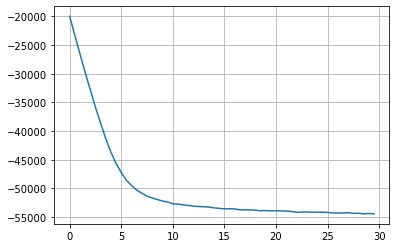

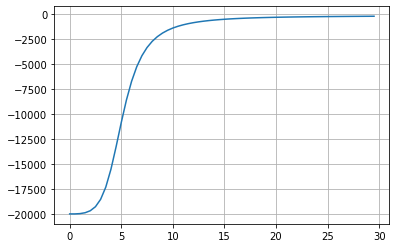

In [8]:
# Plot
tt = np.arange(0,tf,Ts)
len(tt)
alt = []
vel = []
bal = []
xdot_vel = []
for j in range(len(xlst_alt)):
    alt.append(xlst_alt[j][0][1])
#     vel.append(xlst_vel[j])
#     bal.append(xlst_bal[j])
    xdot_vel.append(xdot_list[j][0][0])
# print(xlst[0][0])
# print(xlst[1][0])
# print(xlst)
# plt.plot(tt,xlst[0:len(tt),0])
# plt.plot(tt,alt)
plt.figure(1)
plt.plot(tt,alt)
plt.grid()

# plt.figure(2)
# plt.plot(tt,vel)
# plt.grid()

# plt.figure(3)
# plt.plot(tt,bal)
# plt.grid()

plt.figure(4)
plt.plot(tt,xdot_vel)
plt.grid()
# np.sum(xlst[0])


